In [1]:
import pandas as pd
import numpy as np
from PIL import Image 
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import cv2
import seaborn as sns


In [2]:
Thickness = pd.read_csv('./data/Thickness.csv')
Thickness = Thickness.drop([33]) # 9-1 drop
Thickness.reset_index(drop=True, inplace=True)
Thickness

,Thickness
0,48.266667
1,47.966667
2,48.166667
3,48.600000
4,59.533333
...,...
122,84.633333
123,98.366667
124,97.033333
125,96.266667


In [3]:
img_path_list = []
Top_change_imp_VS_path = './data/box_img/Top_change_VS_imp/'

for i in range(1, 33):
    for j in range(1, 5):
        if i == 9 and j == 1: 
            continue
        img_path_list.append('./data/test_img/AI-{}_0{}_transformed.jpg'.format(i, j))

전처리한 이미지 RGB / HSV

In [4]:
top_avg_bgr = []
top_avg_hsv = []

for i in range(len(img_path_list)):
    # 이미지 로드
    img = cv2.cvtColor(np.array(Image.open(Top_change_imp_VS_path + 'Top_change_VS_{}.jpg'.format(i))), cv2.COLOR_RGB2BGR)
    # RGB 평균 계산
    avg_bgr = img.mean(axis=(0,1))
    top_avg_bgr.append(avg_bgr)
    # HSV 평균 계산
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    avg_hsv = img_hsv.mean(axis=(0,1))
    top_avg_hsv.append(avg_hsv)

In [5]:
Table_dataset = pd.DataFrame({'Top_R' : [i[2] for i in top_avg_bgr], 
                              'Top_G' : [i[1] for i in top_avg_bgr], 
                              'Top_B' : [i[0] for i in top_avg_bgr],
                              'Top_H' : [i[0] for i in top_avg_hsv], 
                              'Top_S' : [i[1] for i in top_avg_hsv], 
                              'Top_V' : [i[2] for i in top_avg_hsv],
                              'Thickness': Thickness['Thickness']})

Table_dataset

,Top_R,Top_G,Top_B,Top_H,Top_S,Top_V,Thickness
0,11.5752,10.8824,8.0332,22.1580,79.0864,11.5752,48.266667
1,10.2804,10.4340,9.0232,23.5584,41.5664,10.5508,47.966667
2,10.0228,9.9236,7.9204,29.0352,56.4348,10.0308,48.166667
3,8.3744,8.5136,6.1348,26.7236,77.8136,8.6560,48.600000
4,4.1716,2.2884,1.1488,27.9292,211.7900,4.3000,59.533333
...,...,...,...,...,...,...,...
122,1.8884,5.0128,18.5152,114.3780,229.4796,18.5152,84.633333
123,6.9784,15.3760,26.5632,106.8272,188.4016,26.5632,98.366667
124,3.3400,13.3692,33.3720,109.8596,230.0004,33.3720,97.033333
125,5.8372,15.0308,31.7036,109.2272,208.5904,31.7036,96.266667


안쓸피쳐드랍

In [6]:
Table_dataset = Table_dataset.drop(['Top_H', 'Top_S', 'Top_V'], axis=1)
Table_dataset

,Top_R,Top_G,Top_B,Thickness
0,11.5752,10.8824,8.0332,48.266667
1,10.2804,10.4340,9.0232,47.966667
2,10.0228,9.9236,7.9204,48.166667
3,8.3744,8.5136,6.1348,48.600000
4,4.1716,2.2884,1.1488,59.533333
...,...,...,...,...
122,1.8884,5.0128,18.5152,84.633333
123,6.9784,15.3760,26.5632,98.366667
124,3.3400,13.3692,33.3720,97.033333
125,5.8372,15.0308,31.7036,96.266667


데이터 나누기

In [7]:
X_train, X_test, y_train, y_test = train_test_split(Table_dataset.iloc[:, :-1], Table_dataset.iloc[:, -1], test_size=0.3, random_state=42)

TPOT모델 찾기

# 🎯모델 1

In [8]:
from tpot import TPOTRegressor

tpot =  TPOTRegressor(generations=20, population_size=5, verbosity=2, random_state=42, cv=3, n_jobs = -1)
tpot.fit(X_train, y_train)

tpot.export('tpot_pipeline_cv.py')

                                                                            
Generation 1 - Current best internal CV score: -166.96914055118933
                                                                             
Generation 2 - Current best internal CV score: -166.96914055118933
                                                                             
Generation 3 - Current best internal CV score: -166.96914055118933
                                                                             
Generation 4 - Current best internal CV score: -166.96914055118933
                                                                             
Generation 5 - Current best internal CV score: -166.96914055118933
                                                                             
Generation 6 - Current best internal CV score: -166.96914055118933
                                                                             
Generation 7 - Current best internal CV score: -166.9

In [9]:
y_pred = tpot.predict(X_test)
y_pred

/home/hakki/anaconda3/envs/torch2.0/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(


array([ 73.37733738,  61.7358895 ,  73.29786374, 109.83684599,
        97.34279172,  64.74779826,  64.2868997 ,  97.26776696,
        64.74779826, 109.98855637,  99.18464689,  61.40907561,
        84.95406327,  61.51380136,  79.78040793, 102.73523227,
        83.58587961,  80.0172641 ,  64.74779826,  83.5121421 ,
        64.74779826,  64.71161076,  83.38161922, 106.74284545,
        67.46317083, 110.80440969, 109.87034043, 106.39351479,
        73.37733738,  83.2929187 ,  62.5589185 ,  73.22717387,
        72.66740238, 109.87034043,  97.97888999, 101.9475756 ,
        72.49700858, 105.10322278,  74.34299336])

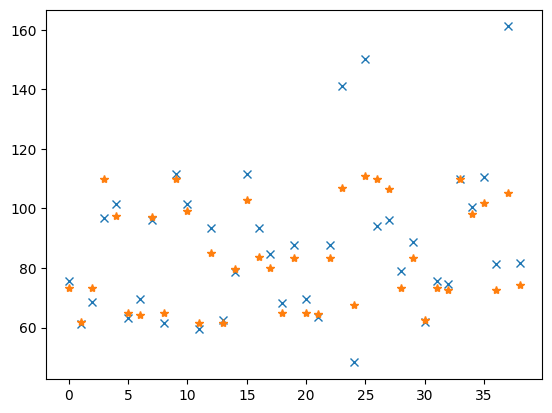

In [10]:
plt.plot(y_test.values,'x', label = 'True')
plt.plot(y_pred,'*', label = 'Predict')

In [11]:
pd.DataFrame({'True': y_test.values, 'Predict': y_pred})

,True,Predict
0,75.533333,73.377337
1,61.300000,61.735890
2,68.700000,73.297864
3,96.633333,109.836846
4,101.466667,97.342792
5,63.166667,64.747798
6,69.433333,64.286900
7,96.266667,97.267767
8,61.466667,64.747798
9,111.533333,109.988556


In [12]:
mse = np.mean((y_pred - y_test)**2)
mse

191.9476380880887

# 🎯 모델 2

In [13]:
tpot =  TPOTRegressor(generations=5, population_size=50, verbosity=2, random_state=42, cv=5, n_jobs = -1)
tpot.fit(X_train, y_train)

tpot.export('tpot_pipeline_cv.py')

                                                                             
Generation 1 - Current best internal CV score: -118.80325313447773
                                                                              
Generation 2 - Current best internal CV score: -118.80325313447773
                                                                              
Generation 3 - Current best internal CV score: -118.80325313447773
                                                                              
Generation 4 - Current best internal CV score: -118.80325313447773
                                                                              
Generation 5 - Current best internal CV score: -118.80325313447773
                                                                              
Best pipeline: KNeighborsRegressor(input_matrix, n_neighbors=5, p=2, weights=distance)


In [14]:
y_pred = tpot.predict(X_test)
y_pred

array([ 74.2597185 ,  61.75743227,  75.23415128, 106.70990207,
        99.10784488,  63.79514632,  72.63131236,  98.73911925,
        63.64039703, 102.34396162, 101.46635718,  61.67967081,
        86.24039884,  61.70354514,  78.6595593 , 104.43325031,
        85.21829126,  79.90369172,  66.22154249,  87.79373835,
        65.67425534,  62.97527802,  83.27997888, 127.87907663,
        53.92069092, 115.35200957, 106.73120869, 107.61984052,
        74.089875  ,  91.06263211,  61.81813654,  75.93849573,
        72.36844909, 106.66672018,  98.56638838,  89.4218592 ,
        74.05398384, 122.7254863 ,  77.04713311])

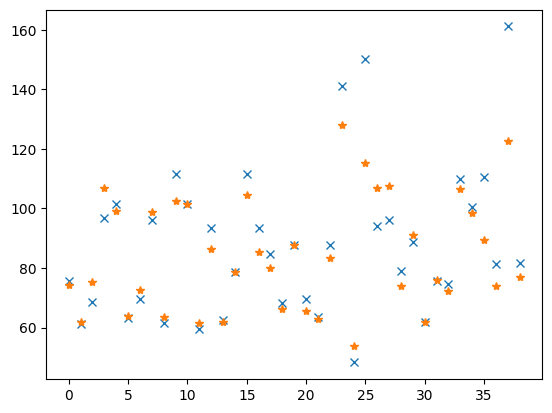

In [15]:
plt.plot(y_test.values,'x', label = 'True')
plt.plot(y_pred,'*', label = 'Predict')

In [16]:
pd.DataFrame({'True': y_test.values, 'Predict': y_pred})

,True,Predict
0,75.533333,74.259718
1,61.300000,61.757432
2,68.700000,75.234151
3,96.633333,106.709902
4,101.466667,99.107845
5,63.166667,63.795146
6,69.433333,72.631312
7,96.266667,98.739119
8,61.466667,63.640397
9,111.533333,102.343962


In [17]:
mse = np.mean((y_test.values - y_pred)**2)
mse


108.91347824675009